# Abrstract
Artitifial Intelligenece (AI), is the intelligence demonstrated by machines opposed to that of animals including, humans. This is ability of a computer systems or robot/electronics device to do tasks that are ussually done by humans because they require human/animal intelligence and discrement, such tasks includes natural language processing, decision-making, visual perception, drug discovery, etc. 

## Machine Learning
Machine Learning (ML) is an application of AI that enables systems to learn and advance based on experience without being explicitly programmed. ML focuses on development of computer systems that can learn from data given and draw experience based on data patterns.

Machine Learning is application of Inferential Statistics, unlike normal Statistical models which are designed for inference about the relationships between variables, machine learning models ML is designed to make most accurate predictions possible this is possible thanks to imporved Computations and Amount of Data produced.

>  **ML is to Statistics as Engineering to Physics**

### Types of Machine Learning

#### 1. Supervised Learning
This is the type of Machine Learning that use labeled examples to train machine learning to train Machine Learning models that can be used classify data or predict. In this type of Machine Learning the possible outcomes are already known and that the data used to train the model is already lebled.

#### 2. Unsupervised Learning
Unlike Supervised Learning Machine Learning tasks, Unsupervised Learning finds patterns where we don't.
Advances of this type of ML is very important to future of AI as it moves AI closer to the Artitifial general Intelligence, such advancement is Generative Adversarial Networks.

#### 3. Semi-supervised Learning
This is somethime between the above two types, this is used when AI problem required balance of Supervised Learning and unsupervised learning. This invloves creating a machine learning model from small amount of labeled examples and then uses it with unlabeled examples to predict the outputs, linking the outcome and then retrain the model.

#### 4. Reinforcement Learning
This is the type of dynamic programming that is used to train a machine learning models using systems of reward and punishment. The reiforcement agent learns by intertacting with environment, it receives reward by performing correctly and penalties when doing a task incorrectly. The reiforcement agent learns without having to be directly taught by a human.
The agent learns to maximize the reward and minimize the penalty.

Example of such agent will an AI agent that play a computer game or an autonomous robot or vehicle.

## Deep Learning
Deep Leaning is the Specialize form of machine learning. It imitates the working of human brain in processing data and creating partterns. Deep learning uses Networks of Artifical neural networks for machine learning process.

This Neural networks are built to resemble the human Neurons, in Deep Learning these Neural networks are designed to process data in non linear way.

A standard Machine Learning workflow starts with manually extracting selected features (Consider an Image), normally we will require to get color distribution, pixels invomations, e.t.c. A deep learning workflow differs from this as relevant features are extracted automatically.

Deep learning Models are sometimes considered **Universal Functions Estimators** and therefore they outperfoms most Machine Learning algorithms

In this Notebook will only limited to convolution neural networks (Focusing on Variant of called resudal networks), also will not go beyond Computer vision.

# Inroduction

A convolutional Neural networks are types of Deep Neural networks used in computer visions applications like (Image classifications, Object Detections).

Depending on type of use cases and other factors such as accuracy, computions there are varians of CNN architectures.

In this book we will implement one of theses architectures called [ResNet](https://arxiv.org/abs/1512.03385)

## ResNet
RestNet has Multiple configuration which specify the number of layers and sizes of those layers. Each layer is made out of blocks, made of convolutional layers, bacth normaliztion layers and residual connections (also called skip connections or shortcut connections).

ResNet uses the term layer to refer to both a set of blocks e.g "layer 1 has two blocks", and also the total number of layers within the entire ResNet, e.g "ResNet18 has 18 layers".

A residual connection is simply a direct connection between the input of a block and the output of block.

It is possible to add layers in residual connection.

Residual Network architecture

![resnet](https://d2l.ai/_images/resnet-block.svg)

The different configurations of ResNet
![resnet](https://miro.medium.com/max/1400/1*I2557MCaFdNUm4q9TfvOpw.png)

From the table above, we can see that for ResNet18 and ResNet34 that the first block contains two 3x3 convolutional layers with 64 filters, and that ResNet18 has two of these blocks in the first layer, whilst Resnet34 has three. ResNet50, ResNet101 and ResNet152 blocks have a different structure than those in ResNet18 and ResNet34, and these blocks are called bottleneck blocks. Bottleneck blocks reduce the number of number of channels within the input before expanding them back out again. Below shows a standard BasicBlock (left) - used by ResNet18 and ResNet34 - and the Bottleneck block used by ResNet50, ResNet101 and ResNet152.

### Why ResNet Works
Normally training deep learning is very difficult due to the gradient descent either exploding or vanishing as it get backprogated through many layers, the residual connection allow the model to skip layers, by setting all their weighs to zero and only rely on the residual connection.

In theory, if your ResNet152 model can actually learn the desired function between input and output by only using the first 52 layers the remaining 100 layers should set their weights to zero and the output of the 52nd layer will simply pass through the residual connections unhindered. This also allows for the gradient signal to also backpropagate through those 100 layers unhindered too.

# Setup
In this document we will show how to prepare image datasets for image classification, training, validation, and monitoring the model training

## Libraries and dependencies

We will be using PyTorch as our primary Deep learning library to due it is friendly Syntax and ecosystem integration.

We will use Sklearn to capture model metrics like ConfusionMatrix, and matplotlib for plotting training results

To help with training and evaluting neural networks in PyTorch flexibly and transparently we will use PyTorch Ignite.

We will use TensorBoard, and WandB(Weights and Bias) to monitor training process. TensorBoard provides the visualization and tooling needed for machine learning experimentation, for tracking and visualizing metrics such as loss and accuracy, Visualizing the model graph.

WandB is the alternative to TensorBoard that can help you to track metrics similar to TensorBoard with addition to system metrics


In [1]:
# !pip install pytorch-ignite

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import FastaiLRFinder
from ignite.contrib.handlers.wandb_logger import *
from ignite.handlers import ModelCheckpoint, global_step_from_engine
from ignite.contrib.handlers import TensorboardLogger
from ignite.engine import Events
from ignite.metrics import Accuracy, Loss, Precision, Recall, ConfusionMatrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt
from ResNet import *
import numpy as np
import copy
import os
import random
import shutil

In [3]:
# !pip install pytorch-ignite

#### Reproducability

A random seed is used to ensure that results are reproducible. In other words, using this parameter makes sure that anyone who re-runs your code will get the exact same outputs. Reproducibility is an extremely important concept in data science and other fields.

Deterministic operations are often slower than nondeterministic operations, so single-run performance may decrease for your model. However, determinism may save time in development by facilitating experimentation, debugging, and regression testing.

In [4]:
# Setting up random seed to ensure repoducibility
SEED = 500

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

%env WANDB_MODE=offline
%env WANDB_SILENT=true

env: WANDB_MODE=offline
env: WANDB_SILENT=true


In [5]:
# REPLACE THESE WITH YOUR OWN KAGGLE USERNAME AND KEY
"""
This step is only important if you want to download data from Kaggle.
"""
os.environ['KAGGLE_USERNAME'] = "januarymagori"
os.environ['KAGGLE_KEY'] = "bc6ce7bdd037b4b7edf3c329d842f4f3"

# !kaggle datasets download smaranjitghose/corn-or-maize-leaf-disease-dataset --unzip
# !mkdir datasets/maize-leaf-disease-dataset/
# !cp -R data/ datasets/maize-leaf-disease-dataset/images/
# !rm -rf data/

#### Dataset organization
We suggest all the datasets are arranged in the following form

```---> datasets/
        ---> application-name/
                ---> images/
                    ---> class1/
                    ---> class2/
                    ---> classN/




In [6]:
ROOT = 'datasets/'
application_name = 'mangoes-leaves'

# Data preparation

This is very important part in any machine learning problem since data is main fuel to Machine Learning models, therefore data should be prepared in best way possible.

## Train-Tes Split
The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

This requires that the original dataset to be a suitable representation of the problem domain.

> This procedure is not advised when the dataset is small, the reason is it will cause the model to have few examples to learn from

For Insuffienct data other methods can be used like 
* K Cross Validation
* Leave One Out cross validation
* Stratified
* Repeated
* Nested

Those methods are out scope in this implementation and will not be discussed

This Example we will split train-test into 80% and 20% ratio (For experimenting we can try different ratios)

## Data Imblance
Imbdalanced data refers to those types of datasets where the target class has uneven distribution of observations.

Due to challenges in getting data from the data for training the model, and may lead to bias in classifier.

To explain data Imbalance we will use Confusion Matrix, to show how the model classifies the target classes and evaluate the model accuracy.

### Dealing with Imbdalanced datasets
1. Model Metrics
The Accuracy
The accuracy of a classifier is the total number of correct predictions by the classifier divided by the total number of predictions.
This is good for balanced datasets but not for imbalanced datasets.

Precision and Recall
Precision is the measure of how accurate the classifier’s prediction of a specific class and recall is the measure of the classifier’s ability to identify a class.

> We don't expect much impact of balanced datasets but we will store our mode based on F1 score and Accuracy

2. Resampling and Undersampling
This technique is used to upsample or downsample the minority or majority class. When we are using an imbalanced dataset, we can oversample the minority class using replacement. This technique is called oversampling. Similarly, we can randomly delete rows from the majority class to match them with the minority class which is called undersampling.

3. SMOTE
Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often don’t add any new information to the model.

4. Threshold moving
In the case of our classifiers, many times classifiers actually predict the probability of class membership. We assign those prediction’s probabilities to a certain class based on a threshold which is usually 0.5, i.e. if the probabilities < 0.5 it belongs to a certain class, and if not it belongs to the other class.

For imbalanced class problems, this default threshold may not work properly. We need to change the threshold to the optimum value so that it can efficiently separate two classes. We can use ROC Curves and Precision-Recall Curves to find the optimal threshold for the classifier. We can also use a grid search method or search within a set of values to identify the optimal value.

In [7]:
"""
Spliting train and test data in 80:20 ratio

From our standard dataset organization, we have the following directory structure:
images/ folder this should contain all our images separated by class names

train/ folder this should contain all our training images
test/ folder this should contain all our testing images

"""

TRAIN_RATIO = 0.8
data_dir = os.path.join(ROOT, application_name)
images_dir = os.path.join(data_dir, 'images')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if os.path.exists(train_dir):
    shutil.rmtree(train_dir) 
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(train_dir)
os.makedirs(test_dir)

classes = os.listdir(images_dir)

for c in classes:
    
    class_dir = os.path.join(images_dir, c)
    
    images = os.listdir(class_dir)
       
    n_train = int(len(images) * TRAIN_RATIO)
    
    train_images = images[:n_train]
    test_images = images[n_train:]
    
    os.makedirs(os.path.join(train_dir, c), exist_ok = True)
    os.makedirs(os.path.join(test_dir, c), exist_ok = True)
    
    for image in train_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(train_dir, c, image)
        try:
            shutil.copyfile(image_src, image_dst)
        except:
            pass
        
    for image in test_images:
        image_src = os.path.join(class_dir, image)
        image_dst = os.path.join(test_dir, c, image) 
        try:
            shutil.copyfile(image_src, image_dst)
        except:
            pass

## Image Processing

### Datasets and Dataloaders

PyTorch provide are very easy way of processing data samples and maintaining them.

It is good practice to decouple our datasets code from our model training code for modularity and maintainability.

Pytorch Provide two primitives: <pre><code>torch.utils.data.DataLoader</code></pre> <pre><code>torch.utils.data.Dataset</code></pre> 
that allows loading pre-loaded datases or custom datasets

### Image Normalization
Image Normalization is a the process of changing the range of pixel intensity values, the reason we require this step is because during the training process we are goin to multiply weights and adding to (biases) in order to cause activation that we then propagate with gradient to train the model. This process should be repeated for each feature so our gradient remains in control.

### Transformation
In order to improve our model accuracy we need to make some transforms to our datasets, such cropping, rotation, scalling and also we need to transform the image into **Tensor** that can be used as input to our model

In [8]:
"""
Loading custom data from the train and test folders,

Also we calculate means and standard deviation that we'll use for Normalization
"""
train_data = datasets.ImageFolder(
    root = train_dir,
    transform = transforms.ToTensor()
)
means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

# Calculated means: tensor([0.2399, 0.2776, 0.2590])
# Calculated stds: tensor([0.0703, 0.0997, 0.0848])

# Calculated means: tensor([0.7322, 0.6320, 0.5282])
# Calculated stds: tensor([0.2886, 0.3069, 0.3414])

Calculated means: tensor([0.2146, 0.2556, 0.2493])
Calculated stds: tensor([0.0662, 0.0954, 0.0837])


In [9]:
"""
we need to apply different transformation to help our model generalize the data, and
In this step we resize our dataset into a fixed size (32 x 32) we choose this to increase the training process
We apply random horizontal flipping, rotation and crop

After transformation we apply it loaded image
"""
train_transforms = transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(32, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.CenterCrop(32),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = means, 
                                                std = stds)
                       ])

train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [10]:
VALID_RATIO = 0.1

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3
Number of validation examples: 33
Number of testing examples: 10


In [11]:
"""
We will load 32 images at a time to train our model and we will use the same during validation
num_workers = 0 means that we will use only one core to load the data, PyTorch provide parallel training in case we use multi-core GPU/CPU
"""

BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                num_workers=0,
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
num_workers=0,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [12]:
"""
Normalize Images
"""
def normalize_image(image):
    image_min = image.min()
    image_max = image.max() 
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image    

In [13]:
def plot_images(images, labels, classes, normalize = True):
    """
    It is good practice to visualize dataset before strating working with It to understand the data
    """
    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1 )
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        # plt.hist(image.cpu().numpy().ravel(), bins = 30, density = True)
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

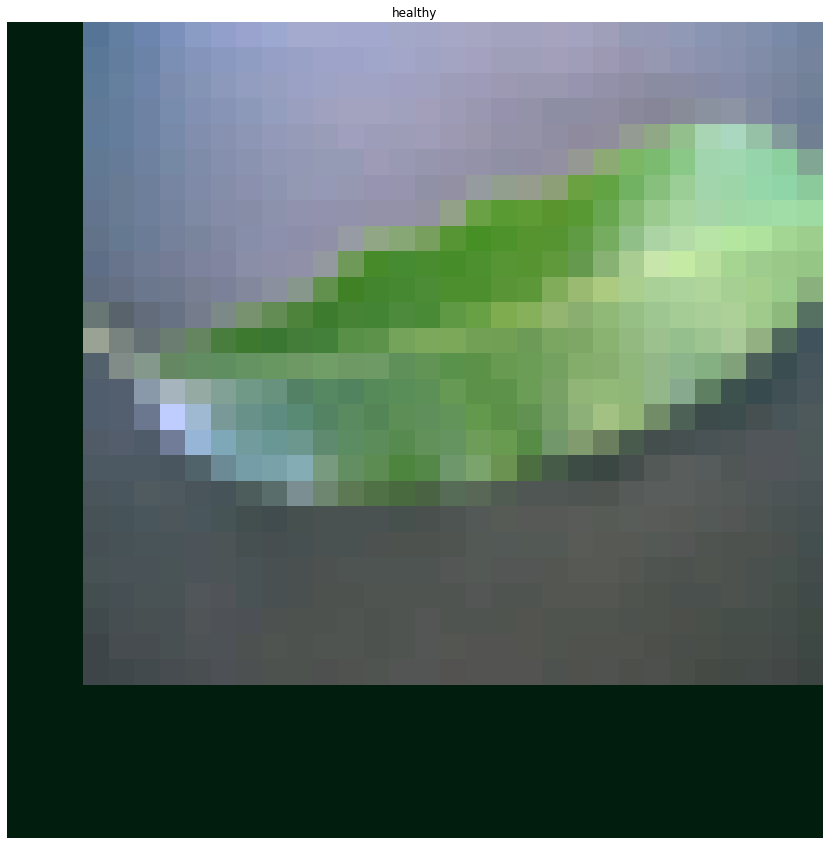

In [14]:
N_IMAGES = 2
images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])
classes = test_data.classes
plot_images(images, labels, classes)

In [15]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

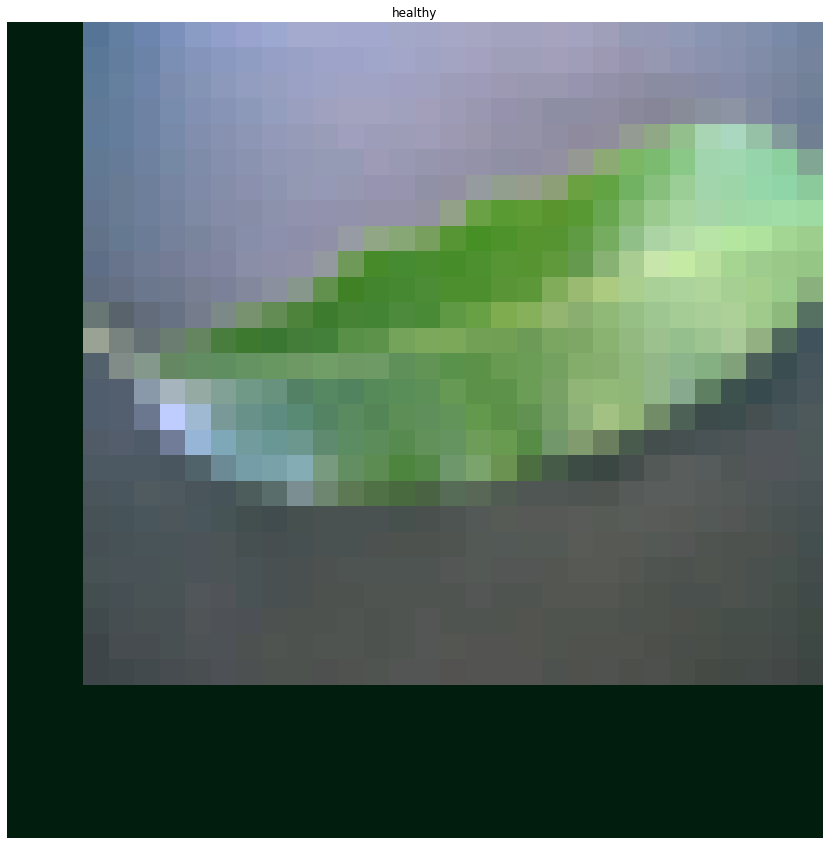

In [16]:
test_data.classes = [format_label(c) for c in test_data.classes]
plot_images(images, labels, classes)

In [17]:
"""
Loading ResNet variant model, we will strat with ResNet18, depending on the permance we can update the model with deeper version
"""

model = resnet18(num_classes=len(classes))

# model = resnet101(num_classes=len(classes))

2


In [18]:
""" 
Number of parameters in the model
"""
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 11,177,538 trainable parameters


[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:02<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

[1/1] 100%|########## [00:00<?]

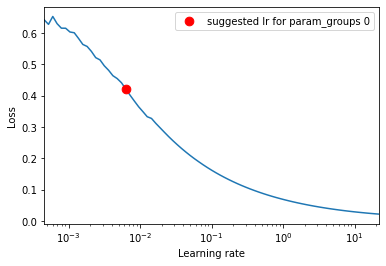

In [19]:
"""
Hyperparameters tuning
Deep learning neural networks are trained using the stochastic gradient descent algorithm.
Stochastic gradient descent is an optimization algorithm that estimates the error gradient for the current state of the model using examples from the training dataset, 
then updates the weights of the model using the back-propagation of errors algorithm,

Learning Rate
The amount that the weights are updated during training is referred to as the step size or the “learning rate.”
Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, 
often in the range between 0.0 and 1.0.

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs 
given the smaller changes made to the weights each update, 
whereas larger learning rates result in rapid changes and require fewer training epochs.

The challenge of training deep learning neural networks involves carefully selecting the learning rate. 
It may be the most important hyperparameter for the model.

Instead of manually tuning the learning rate, we can use the learning rate scheduler to automatically tune the learning rate.
In our case we use FastaiLRFinder to find the best learning rate for our model. 
FastaiLRFinder is based on this paper Cyclical Learning Rates for Training Neural Networks - https://arxiv.org/abs/1506.01186
"""

START_LR = 1e-4
WEIGHT_DECAY = 1e-2

# optimizer = optim.Adam(model.parameters(), lr=START_LR, weight_decay=WEIGHT_DECAY)
optimizer = optim.SGD(model.parameters(), lr=START_LR, weight_decay=WEIGHT_DECAY)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()


lr_finder = FastaiLRFinder()
to_save = {"model": model, "optimizer": optimizer}

trainer = create_supervised_trainer(
    model, optimizer, criterion, device=device
)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})
with lr_finder.attach(trainer, to_save=to_save, end_lr=100, num_iter=100) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_iterator)

from matplotlib import pyplot as plt
ax = lr_finder.plot()
plt.show()

In [20]:
lr_finder.apply_suggested_lr(optimizer)
print(optimizer.param_groups[0]['lr'])

0.006309573444801932


In [21]:
"""
Training Process, we will use egnite to assist training and reporting the learning process.

Validation Metrics
The F1-score combines the precision and recall of a classifier into a single metric by taking their harmonic mean. 
It is primarily used to compare the performance of two classifiers. Suppose that classifier A has a higher recall, and classifier B has higher precision.

Mathematically, the F1-score is defined as: F1 = 2 * (precision * recall) / (precision + recall)

Accuracy
Accuracy is defined as the number of classifications a model correctly predicts divided by the total number of predictions made. 
It's a way of assessing the performance of a model, but certainly not the only way

"""


desc = "ITERATION - loss: {:.2f}"
EPOCHS = 2


# Progress bar
progress_bar = tqdm(
    initial=0, leave=False, total=len(train_iterator), 
    desc=desc.format(0)
)

# Metrics
precision = Precision(average=False)
recall = Recall(average=False)
F1 = (precision * recall * 2 / (precision + recall)).mean()

val_metrics = {
    "accuracy": Accuracy(),
    "loss": Loss(criterion),
    "precision": precision,
    "recall": recall,
    "f1": F1,
    "confusion_matrix": ConfusionMatrix(num_classes=len(classes))
}

# create a confusion Matrix
def transform_confusion_matrix(matrix):
    return matrix.cpu().numpy().astype(int).astype(str)

evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

log_interval = 30

@trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
def log_training_loss(engine):
    """
     Log training loss at log_interval
     """
    progress_bar.desc = desc.format(engine.state.output)
    progress_bar.update(log_interval)

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    """
    Lofts training results at the end of each epoch
    """
    progress_bar.refresh()
    evaluator.run(train_iterator)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics["accuracy"]
    avg_loss = metrics["loss"]
    
    tqdm.write(
        "Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
        .format(engine.state.epoch, avg_accuracy, avg_loss)
    )

def score_function(engine):
    return engine.state.metrics['f1']

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(valid_iterator)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics["accuracy"]
    avg_loss = metrics["loss"]

    tqdm.write(
        "Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
        .format(engine.state.epoch, avg_accuracy, avg_loss)
    )
   
model_checkpoint = ModelCheckpoint(
        dirname="{}/models/f1".format(application_name),
        n_saved=2,
        require_empty=False,
        filename_prefix="best_{}".format(application_name),
        create_dir=True,
        score_function=score_function,
        score_name="f1", # accuracy
        global_step_transform=global_step_from_engine(trainer),
)

# Use this if you want to get the model based on accuracy

_model_checkpoint = ModelCheckpoint(
        dirname="{}/models/accuracy".format(application_name),
        n_saved=2,
        require_empty=False,
        filename_prefix="best_{}".format(application_name),
        create_dir=True,
        score_function=score_function,
        score_name="accuracy", # accuracy
        global_step_transform=global_step_from_engine(trainer),
)
evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {
    "model": model,
})

evaluator.add_event_handler(Events.COMPLETED, _model_checkpoint, {
    "model": model,
})

"""
Logging and monitoring
"""
# wandb_logger = WandBLogger(
#     project=application_name,
#     anonymous="allow",
#     name=application_name,
#     config={"max_epochs": EPOCHS, "batch_size": BATCH_SIZE},
# )

# wandb_logger.attach_output_handler(
#     trainer, Events.ITERATION_COMPLETED,
#     tag='training',
#     output_transform=lambda loss: {'loss': loss},
# )
# wandb_logger.attach_output_handler(
#     evaluator, Events.EPOCH_COMPLETED,
#     tag='training',
#     metric_names='all',
#     global_step_transform=lambda *_: trainer.state.iteration,
# )
# wandb_logger.attach_opt_params_handler(
#     trainer, Events.ITERATION_STARTED,
#     optimizer=optimizer,
#     param_name='lr',
# )

tensorboard_logger = TensorboardLogger(
    log_dir="logs-{}".format(application_name),
)
tensorboard_logger.attach_output_handler(
    trainer, Events.ITERATION_COMPLETED,
    tag='training',
    output_transform=lambda loss: {'training loss': loss},
)
tensorboard_logger.attach_output_handler(
    evaluator, Events.EPOCH_COMPLETED,
    tag='validation',
    metric_names='all',
    global_step_transform=global_step_from_engine(trainer),
)

class ImageDenomalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def predictions_get_images_handler(engine, logger, *args, **kwargs):
    x, _ = engine.state.batch
    y_pred, y = engine.state.output
    num_x = num_y = len(classes)
    le = num_x * num_y
    probs, preds = torch.max(torch.exp(y_pred[:le]), dim=1)
    fig = plt.figure(figsize=(16, 16))
    for idx in range(le):
        ax = fig.add_subplot(num_x, num_y, idx + 1, xticks=[], yticks=[])
        
        try:
            # image = x[idx].numpy().transpose((1, 2, 0))
            # image = x[idx].permute(1, 2, 0) 
            image = x[idx]

            unormalized_image = ImageDenomalize(
                mean=means, std=stds
            )
            image = unormalized_image(image)
            image = transforms.ToPILImage(mode='RGB')(image)
        except:
            continue

        ax.imshow(
            image, cmap="Greys"
        )
        ax.set_title("Preds: {0} {1:.1f}%, Actual: (label: {2})".format(
            classes[preds[idx]],
            probs[idx],
            classes[y[idx]]
        ), color=("green" if preds[idx] == y[idx] else "red"))
    logger.writer.add_figure(
        "Predictions vs actuals", figure=fig, global_step=trainer.state.epoch
    )

def plot_confusion_matrix(engine, logger, *args, **kwargs):
    confusion_matrix_data = engine.state.metrics['confusion_matrix'].numpy()
    
    fig = plt.figure(figsize=(16, 16))
    ax = fig.add_subplot(1, 1, 1)
    _confusion_matrix = ConfusionMatrixDisplay(confusion_matrix_data, display_labels=classes)
    _confusion_matrix.plot(ax=ax, cmap='Blues', values_format='d')
    plt.xticks(rotation=45)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)
    logger.writer.add_figure(
        "Confusion Matrix", figure=fig, global_step=trainer.state.epoch
    )

tensorboard_logger.attach(
    evaluator,
    event_name=Events.ITERATION_COMPLETED(once=1),
    log_handler=predictions_get_images_handler,
)
tensorboard_logger.attach(
    evaluator,
    event_name=Events.EPOCH_COMPLETED,
    log_handler=plot_confusion_matrix,
)

# wandb_logger.watch(model, log="all")
trainer.run(train_iterator, max_epochs=EPOCHS)

progress_bar.close()
tensorboard_logger.close()


# and attach it to evaluator

# wandb_logger._wandb.finish()

# f102268ac0afc1f2162c032ef8401883971ada66


ITERATION - loss: 0.00:   0%|                                                                 | 0/1 [00:14<?, ?it/s]C:\Users\DeeCompanyLtd\anaconda3\lib\site-packages\ignite\contrib\handlers\base_logger.py:135: UserWarning: Logger output_handler can not log metrics value type <class 'torch.Tensor'>
  warnings.warn(f"Logger output_handler can not log metrics value type {type(value)}")

                                                                                                                 
ITERATION - loss: 0.00:   0%|                                                                 | 0/1 [00:20<?, ?it/s]

Training Results - Epoch: 1  Avg accuracy: 0.33 Avg loss: 11.81



                                                                                                                 
ITERATION - loss: 0.00:   0%|                                                                 | 0/1 [00:53<?, ?it/s]

Validation Results - Epoch: 1  Avg accuracy: 0.55 Avg loss: 4.24


[1/1] 100%|########## [00:00<?]


ITERATION - loss: 0.00:   0%|                                                                 | 0/1 [00:55<?, ?it/s]WARNING:root:NaN or Inf found in input tensor.

                                                                                                                 
ITERATION - loss: 0.00:   0%|                                                                 | 0/1 [00:57<?, ?it/s]

Training Results - Epoch: 2  Avg accuracy: 0.33 Avg loss: 22.70



                                                                                                                 
ITERATION - loss: 0.00:   0%|                                                                 | 0/1 [01:15<?, ?it/s]
                                                                                                                    

Validation Results - Epoch: 2  Avg accuracy: 0.55 Avg loss: 9.31


In [22]:
classes_idx = test_data.class_to_idx
classes_idx

{'diseased': 0, 'healthy': 1}

In [23]:
!pip install tensorboardX

In [24]:
"""
Loading trained model, and testing 
"""


from PIL import Image


model_path = "{}/models/f1/best_mangoes-leaves_model_21_f1=1.0000.pt".format(application_name)
trained_model = resnet18(
    num_classes=len(classes_idx),
)
trained_model.load_state_dict(torch.load(model_path, map_location='cpu'))
trained_model.eval()
# ml-classfication/dl-classification/datasets/mangoes-leaves/test/diseased/0012_0002.JPG
image = Image.open("datasets/mangoes-leaves/images/test/diseased/0012_0002.JPG")

trans = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean = means, std = stds)
])
input_tensor = trans(image).unsqueeze(0)
input_tensor = input_tensor.to('cpu')

output = trained_model(input_tensor)

import torch.nn.functional as nnf

prob = nnf.softmax(output, dim=1)
print(prob)

top_p, top_class = prob.topk(1, dim = 1)
prob.tolist()[0]
confidence, label = top_p.tolist()[0][0], top_class.tolist()[0][0]
confidence, label

2


FileNotFoundError: [Errno 2] No such file or directory: 'mangoes-leaves/models/f1/best_mangoes-leaves_model_21_f1=1.0000.pt'